In [83]:
# Author: Ernesto Rodríguez
# github.com/ernestorodg

###############################################################################
## Analyse Bezerra's dataset for intrusion detection using SVM
###############################################################################

In [84]:
import pandas as pd
import numpy as np
import sys

###############################################################################
## Define constants 
###############################################################################


# Random state for reproducibility
STATE = 0
np.random.seed(10)
# List of available attacks on the dataset


# Especific to the repository 
DATASET_DIRECTORY = r'../datasets/Dataset-bezerra-IoT-20200528T203526Z-001/Dataset-IoT/'
NETFLOW_DIRECTORY = r'NetFlow/'


# There are different csv files on the Dataset, with different types of data:

# Some meanings:
# MC: Media Center
# I: One hour of legitimate and malicious NetFlow data from profile.
# L: One hour of legitimate NetFlow data from profile.

MC = r'MC/'


# MC_I_FIRST: Has infected data by Hajime, Aidra and BashLite botnets 
MC_I_FIRST = r'MC_I1.csv'

# MC_I_SECOND: Has infected data from Mirai botnets
MC_I_SECOND = r'MC_I2.csv'

# MC_I_THIR: Has infected data from Mirai, Doflo, Tsunami and Wroba botnets
MC_I_THIRD = r'MC_I3.csv'

# MC_L: Has legitimate data, no infection
MC_L = r'MC_L.csv'



In [85]:
###############################################################################
## Load dataset
###############################################################################
df = pd.read_csv (DATASET_DIRECTORY + MC + NETFLOW_DIRECTORY + MC_I_FIRST)

# We can see that this dataset has a temporal description.
# So it is not a good idea to randomly remove rows

# In this case we drop the index column, since pandas library creates an index
# automatically. 
df = df.drop(df.columns[0], axis=1)

# Also drop columns that has no significant data
df = df.drop(df.columns[14:], axis=1)

# Caso time is not a good feature, for example. for SVM model
df = df.drop(['ts', 'te'], axis=1)

# Counting number of null data
nanColumns = [i for i in df.columns if df [i].isnull ().any ()]

# Remove NaN and inf values
df.replace ('Infinity', np.nan, inplace = True) ## Or other text values
df.replace (np.inf, np.nan, inplace = True) ## Remove infinity
df.replace (np.nan, 0, inplace = True)


df

,Label,td,sa,da,sp,dp,pr,flg,fwd,stos,ipkt,ibyt
0,0,16.00,192.168.1.100,192.168.1.109,53,55800.0,UDP,......,0.0,0.0,1.0,86.0
1,0,16.00,192.168.1.109,192.168.1.100,55800,53.0,UDP,......,0.0,0.0,1.0,70.0
2,0,240798.00,147.231.99.14,192.168.1.109,443,42582.0,TCP,.AP.SF,0.0,0.0,22.0,6640.0
3,0,240798.00,192.168.1.109,147.231.99.14,42582,443.0,TCP,.AP.SF,0.0,0.0,26.0,2486.0
4,0,0.11,192.168.1.100,192.168.1.109,53,47839.0,UDP,......,0.0,0.0,1.0,240.0
...,...,...,...,...,...,...,...,...,...,...,...,...
359962,1,0.00,192.168.1.109,18.226.50.6,16946,23.0,TCP,....S.,0.0,0.0,1.0,40.0
359963,1,248.00,27.201.73.28,192.168.1.109,23,43924.0,TCP,.A..S.,0.0,0.0,1.0,52.0
359964,1,248.00,192.168.1.109,27.201.73.28,43924,23.0,TCP,.A..S.,0.0,0.0,2.0,100.0
359965,1,0.00,39167148175,192.168.1.109,23,52888.0,TCP,.A....,0.0,0.0,1.0,46.0


In [86]:
###############################################################################
## Slice the dataframe (usually the last column is the target)
###############################################################################

X = pd.DataFrame(df.iloc [:, 1:])

# Selecting other columns
# X = pd.concat([X, df.iloc[:, 2]], axis=1)

y = df.iloc [:, 0]
print('Number of not-attacks: ', y.value_counts()[0])
print('Number of attacks: ', y.value_counts()[1])

# See Output, only available on jupyter-notebooks
X

Number of not-attacks:  1355
Number of attacks:  358612


,td,sa,da,sp,dp,pr,flg,fwd,stos,ipkt,ibyt
0,16.00,192.168.1.100,192.168.1.109,53,55800.0,UDP,......,0.0,0.0,1.0,86.0
1,16.00,192.168.1.109,192.168.1.100,55800,53.0,UDP,......,0.0,0.0,1.0,70.0
2,240798.00,147.231.99.14,192.168.1.109,443,42582.0,TCP,.AP.SF,0.0,0.0,22.0,6640.0
3,240798.00,192.168.1.109,147.231.99.14,42582,443.0,TCP,.AP.SF,0.0,0.0,26.0,2486.0
4,0.11,192.168.1.100,192.168.1.109,53,47839.0,UDP,......,0.0,0.0,1.0,240.0
...,...,...,...,...,...,...,...,...,...,...,...
359962,0.00,192.168.1.109,18.226.50.6,16946,23.0,TCP,....S.,0.0,0.0,1.0,40.0
359963,248.00,27.201.73.28,192.168.1.109,23,43924.0,TCP,.A..S.,0.0,0.0,1.0,52.0
359964,248.00,192.168.1.109,27.201.73.28,43924,23.0,TCP,.A..S.,0.0,0.0,2.0,100.0
359965,0.00,39167148175,192.168.1.109,23,52888.0,TCP,.A....,0.0,0.0,1.0,46.0


In [87]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


####################################################################
# Treat categorical data 
####################################################################

cat_cols = X.columns[X.dtypes == 'O'] # Returns array with the columns that has Object types elements

categories = [
    X[column].unique() for column in X[cat_cols]]

for cat in categories:
    cat[cat == None] = 'missing'  # noqa


# Replacing missing values
categorical_imputer = SimpleImputer(missing_values=None, 
                                    strategy='constant', 
                                    fill_value='missing')

X[cat_cols] = categorical_imputer.fit_transform(X[cat_cols])

# Encoding the categorical data
categorical_encoder = OrdinalEncoder(categories = categories)

X[cat_cols] = categorical_encoder.fit_transform(X[cat_cols])

# Scaling new numerical values

numerical_imputer = SimpleImputer(strategy = "mean")
X[cat_cols] = numerical_imputer.fit_transform(X[cat_cols])

numerical_scaler = StandardScaler()
X[cat_cols] = numerical_scaler.fit_transform(X[cat_cols])



In [88]:
####################################################################
# Treat numerical data 
####################################################################

num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')] # Returns array with the columns that has float types elements

# Scaling numerical values

numerical_imputer = SimpleImputer(strategy = "mean")
X[num_cols] = numerical_imputer.fit_transform(X[num_cols])

numerical_scaler = StandardScaler()
X[num_cols] = numerical_scaler.fit_transform(X[num_cols])

X

,td,sa,da,sp,dp,pr,flg,fwd,stos,ipkt,ibyt
0,-0.028457,-0.223579,-1.514354,-1.561993,5.815216,-3.245205,-4.131920,0.0,0.0,-0.009838,-0.007878
1,-0.028457,-0.223133,-1.514344,1.248827,-0.219624,-3.245205,-4.131920,0.0,0.0,-0.009838,-0.007956
2,14.486481,-0.222687,-1.514354,-1.542329,4.384314,-0.072736,-3.643536,0.0,0.0,0.068633,0.023921
3,14.486481,-0.223133,-1.514334,0.582362,-0.177405,-0.072736,-3.643536,0.0,0.0,0.083580,0.003766
4,-0.029415,-0.223579,-1.514354,-1.561993,4.953406,-3.245205,-4.131920,0.0,0.0,-0.009838,-0.007131
...,...,...,...,...,...,...,...,...,...,...,...
359962,-0.029422,-0.223133,1.753477,-0.710231,-0.222872,-0.072736,0.263534,0.0,0.0,-0.009838,-0.008101
359963,-0.014471,6.914251,-1.514354,-1.563505,4.529591,-0.072736,-3.155152,0.0,0.0,-0.009838,-0.008043
359964,-0.014471,-0.223133,1.638047,0.650027,-0.222872,-0.072736,-3.155152,0.0,0.0,-0.006101,-0.007810
359965,-0.029422,6.534916,-1.514354,-1.563505,5.499981,-0.072736,2.705453,0.0,0.0,-0.009838,-0.008072


In [89]:
###############################################################################
## Split dataset into train and test sets if not using cross validation
###############################################################################
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 1/5,
                                                     random_state = STATE)

In [90]:
###############################################################################
## Train the model using learning curve, using cross-validation
###############################################################################

import time
from sklearn.model_selection import learning_curve

# Measure time of training
start_time = time.time()

# Training the model with cross validation approach
train_sizes, train_scores, valid_scores = learning_curve(
                                            SVC(kernel="rbf", random_state=0, gamma=1, C=1), 
                                            X, 
                                            y, 
                                            cv=5,
                                            scoring='f1')
print("--- %s seconds ---" % (time.time() - start_time))


--- 3544.4950819015503 seconds ---


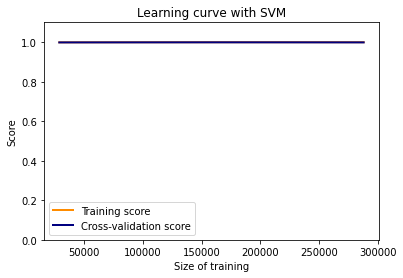

In [91]:
###############################################################################
## Plotting learning curve
###############################################################################
from matplotlib import pyplot as plt

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Learning curve with SVM")
plt.xlabel("Size of training")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(train_sizes, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)

plt.plot(train_sizes, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)

plt.legend(loc="best")
plt.show()


In [92]:
###############################################################################
## Training the model without cross-validation (simpler than the training above)
###############################################################################

# Assign the model to be used
svc = SVC(kernel="rbf", random_state=0, gamma=1, C=1)

# Measure time of this training
start_time = time.time()

# Training the model
model = svc.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

--- 799.7596406936646 seconds ---


In [93]:
###############################################################################
## Obtain metrics from the trained model without cross-validation
###############################################################################

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import multilabel_confusion_matrix


# Predicting from the test slice
y_pred = model.predict(X_test)

# Precision == TP / (TP + FP)
print('Precision Score: ', precision_score(y_test, y_pred))

# Recall == TP / (TP + FN)
print('Recall Score: ', recall_score(y_test, y_pred))

# Accuracy 
print('Accuracy: \n', model.score(X_test, y_test))

# Multilabel Confusion Matrix: 
# [tn fp]
# [fn tp]
print(multilabel_confusion_matrix(y_test, y_pred, labels=[0, 1]))

Precision Score:  0.9989966974624807
Recall Score:  0.999776869761669
Accuracy: 
 0.9987776759174376
[[[71691    16]
  [   72   215]]

 [[  215    72]
  [   16 71691]]]


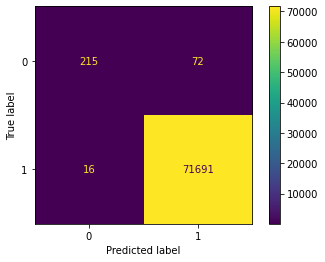

In [94]:
###############################################################################
## Plotting confusion matrix
###############################################################################
from sklearn.metrics import plot_confusion_matrix


plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP